## Семинар 3 "Определение ключевых точек лица"

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  21 октября 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

## Решение

Обучение сети проводилось на колабе с GPU, поэтому в код сети и датасета были внесены соответствующие изменения.

Монтируем Google Drive и распаковываем архив с датасетом в пространстве Colab, устанавливаем необходимые библиотеки.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvzf drive/My\ Drive/nn_sem_3_dataset.tar.gz

In [3]:
!pip install pytorch-ignite
!pip install tensorboardX

     |████████████████████████████████| 184kB 9.2MB/s 
     |████████████████████████████████| 317kB 6.4MB/s 


In [21]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter, Conv2d, MaxPool2d, ReLU
from torch.autograd import Variable
# Ignore warnings
import warnings


try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss



PATH = "nn_sem_3_dataset/"

Я немного изменил класс `Dataset` чтобы быстрее получать данные. Теперь он сразу загружает все изображения и ландмарки в память, приводит их к тензорам и отправляет на GPU.

In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, device="cpu"):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        self.filenames, self.landmarks_tensor = self.__get_landmarks_tensor(csv_file, device)
        self.images = self.__load_images(device)
        
    def __load_images(self, device):
        images = [io.imread(os.path.join(self.root_dir, img_name)) for img_name in self.filenames]
        return torch.Tensor(np.array(images)).to(device)
        
    def __get_landmarks_tensor(self, csv_file, device):
        df = pd.read_csv(csv_file)
        landmarks_tensor = torch.Tensor(df.iloc[:, 1:].values).to(device)
        filenames = df.iloc[:, 0]
        return filenames, landmarks_tensor
        

    def __len__(self):
        return self.landmarks_tensor.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]
        landmarks = self.landmarks_tensor[idx]
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
train_dataset = FaceLandmarksDataset(csv_file=f'{PATH}train/face_landmarks.csv',
                                     root_dir=f'{PATH}train', device="cuda")

test_dataset = FaceLandmarksDataset(csv_file=f'{PATH}test/face_landmarks.csv',
                                     root_dir=f'{PATH}test', device="cuda")

In [7]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.cpu().numpy().shape)
    plt.imshow(grid.cpu().numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].cpu().numpy() + i * im_size,
                    landmarks_batch[i, :, 1].cpu().numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

Были проверены несколько архитектур нейронной сети. Изменение количества слоев и параметров полносвязной сети не привели к улучшению качества (по крайней мере, те изменения, которые я попробовал). Тогда я попробовал использовать сверточную сеть с различным числом сверток. Наилучшее качество было достигнуто с использованием четырех сверточных слоев и learning rate 0.001 -- MSE на тестовой выборке **4.19**.

In [23]:
class Net(Module):
    def __init__(self, activation=Sigmoid(), latent_size=200):
        super().__init__()
        
        # self.fc1 = Linear(96 * 96, 200)
        # self.fc2 = Linear(200, 100)
        # self.fc3 = Linear(100, 68 * 2)
        self.conv1 = Conv2d(1, 4, kernel_size=(3, 3), padding=1)
        self.conv2 = Conv2d(4, 8, kernel_size=(3, 3), padding=1)
        self.conv3 = Conv2d(8, 16, kernel_size=(3, 3), padding=1)
        self.conv4 = Conv2d(16, 32, kernel_size=(3, 3), padding=1)
        # self.conv5 = Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        
        self.fc = Linear(6 * 6 * 32, 68 * 2)

        self.activation = activation
        self.pooling = MaxPool2d(2)
    
    def forward(self, x):
        # fc2_out = self.fc2(self.activation(self.fc1(x.view(x.shape[0], -1)))).view(x.shape[0], 100)
        # return self.fc3(self.activation(fc2_out)).view(x.shape[0], 68, 2)

        conv1_out = self.pooling(self.activation(self.conv1(x.view(x.shape[0], 1, 96, 96))))
        conv2_out = self.pooling(self.activation(self.conv2(conv1_out.view(x.shape[0], 4, 48, 48))))
        conv3_out = self.pooling(self.activation(self.conv3(conv2_out.view(x.shape[0], 8, 24, 24))))
        conv4_out = self.pooling(self.activation(self.conv4(conv3_out.view(x.shape[0], 16, 12, 12))))
        # conv5_out = self.pooling(self.activation(self.conv5(conv4_out.view(x.shape[0], 32, 6, 6))))
        # return conv5_out
        return self.fc(conv4_out.view(x.shape[0], -1)).view(x.shape[0], 68, 2)
        # conv5_out = self.pooling(self.activation(self.conv5(conv4_out.view(x.shape[0], 6 ** 2, 16))))


In [10]:
network = Net()

train_batch_size=64
val_batch_size=64
train_dataloader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False)

writer = SummaryWriter(filename_suffix='first', logdir="out_logs")

device = "cuda"
network.to(device)
criterion = MSELoss()
optim = torch.optim.Adam
# optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
learning_rate = 1e-3
max_epochs = 10

optimizer = optim(network.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)

training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

In [11]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))

In [12]:
trainer.run(train_dataloader, max_epochs=500)

Training/Validation Results - Epoch: 500  Avg MSE: 2.45 / 4.19 Avg MAE: 1.09 / 1.34

State:
	iteration: 49000
	epoch: 500
	epoch_length: 98
	max_epochs: 500
	output: 2.355719566345215
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [13]:
torch.save(network.state_dict(), "model_05")

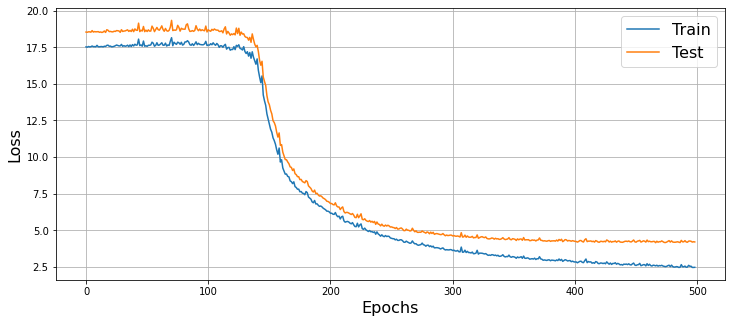

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

Сеть достаточно хорошо сходится за 400-500 эпох.

(2, 96, 96)


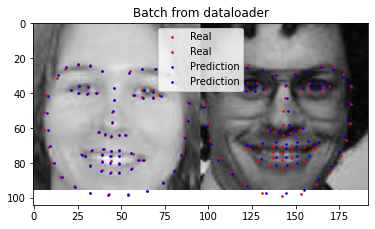

In [15]:
test_dataloader = DataLoader(
        test_dataset, batch_size=2, shuffle=True)

images_batch = next(iter(test_dataloader))
x, y = images_batch
y_pred = network(x)
y_pred = y_pred.data.cpu().numpy()
show_landmarks_batch(images_batch, y_pred)

Визуально сеть расставляет ландмарки близко к правильным меткам, лучше, чем это делала полносвязная архитектура.

In [16]:
img = io.imread("/content/56cdae63c14b6153137135d0.jpg")
rgb2gs = np.array([0.2989, 0.5870, 0.1140])
img = np.dot(img, rgb2gs)

pool = MaxPool2d(2)
img_pooled = pool(torch.Tensor(img).view(1, 280, 400))
img_crop = img_pooled[0, 20:116, 54:150]
img_crop = img_crop.reshape(1, 96, 96)

На фотографии не из датасета, кажется, тоже все неплохо.

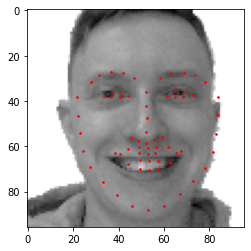

In [19]:
result = network(img_crop.to(device))[0].detach().cpu().numpy()
plt.scatter(result[:, 0], result[:, 1], c="red", marker=".", s=10)
plt.imshow(img_crop[0], cmap="gray")